In [154]:
import ta
import trendet
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import sys
sys.path.append('/Users/jp/Desktop/Investment/utils')
import utils as utils

In [359]:
class Macd_long_backtester():
    
    """Macd class for backtesting strategies
    """
    
    def __init__(self, start=None, end=None, symbol=None):
        
        """Macd long backtester constructor
        :param start: a string with the following format ""%Y-%m-%d-%H:%M:%S" .i.e. "2022-01-29-20:00:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M:%S" .i.e. "2022-02-29-20:00:00"
        :type end: str.
        :param symbol: symbol from Binance from which to extract the data, .i.e. 'BTCUSDT'
        :type symbol: str.
        :param data: a dataframe with all the data extract from the Binance API for the selected function inputs.
        :type data: DataFrame
        :param data_uptrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_uptrend: str.
        :param data_downtrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_down_trend: str.
        :param data_sideways: a dataframe with data extracted from self.data but only for the type of trend
        :type data_sideways: str.
        """
        
        self.symbol = symbol
        self.start = start
        self.end= end
        self.data_init = pd.DataFrame()
        self.data_strategy = pd.DataFrame()
        self.trend_assigned = None
#         self.data_uptrend = pd.DataFrame()
#         self.data_downtrend = pd.DataFrame()
#         self.data_sideways = pd.DataFrame()
#         self.ema_slow = ema_slow
#         self.ema_long = ema_long
#         self.ema_signal = ema.signal
        pass
    
    def __repr__(self):
        return f"Macd_long_backtester(start={self.start}, end={self.end}, symbol={self.symbol})"
    
    def assign_trend(self, window_size=5, plot=False):
        
        if (self.trend_assigned == True): 
            print("The trends have already been assigned, please execute first 'clean_assign_trend' before executing this method again")
            return
        
        sns.set(style='darkgrid')
        res = trendet.identify_df_trends(df=self.data_init, column='Close', window_size=window_size)
        
        if (plot == True):
        
            plt.figure(figsize=(20, 10))
            ax = sns.lineplot(x=res.index, y=res['Close'])

            labels = res['Up Trend'].dropna().unique().tolist()

            for label in labels:
                print(label)
                sns.lineplot(x=res.loc[res['Up Trend'] == label].index, y=res.loc[res['Up Trend'] == label].Close, color='green')
                pol1 = ax.axvspan(res.loc[res['Up Trend'] == label].index[0], res.loc[res['Up Trend'] == label].index[-1], alpha=0.2, color='green')
                coord = pol1.get_xy()
                xcoord = -2 + coord[0][0] + (coord[2][0] - coord[1][0])/2
                ax.annotate(label, (xcoord, 67500))
            
            labels = res['Down Trend'].dropna().unique().tolist()

            for label in labels:
                sns.lineplot(x=res.loc[res['Down Trend'] == label].index, y=res.loc[res['Down Trend'] == label].Close, color='red')
                pol2 =ax.axvspan(res.loc[res['Down Trend'] == label].index[0], res.loc[res['Down Trend'] == label].index[-1], alpha=0.2, color='red')
                coord = pol2.get_xy()
                xcoord = -2 + coord[0][0] + (coord[2][0] - coord[1][0])/2
                ax.annotate(label, (xcoord, 20000))
            
        self.trend_assigned = True
            
    def get_trends(self):
        #the rows where uptrend and downtrend have a NaN value means a market "sideways"

        
        pass
    
    def clean_assign_trend(self):
        '''Delete the columns 'Up Trend' and 'Down Trend' generated by the 'assign_trend method'
        '''
        self.data_init.drop(columns=['Up Trend', 'Down Trend'], inplace=True)
        self.trend_assigned = False
    
    def prepare_data(self, interval=None, ema_slow=None, ema_fast=None, ema_signal=None):
        '''Prepare all the fields of data necessary for the study
        :param ema_slow: integer representing the length of the ema for the slow part of the macd
        :type ema_slow: int.
        :param ema_fast: integer representing the length of the ema for the fast part of the macd
        :type ema_fast: int.
        :param ema_signal: integer representing the length of the ema for the macd signal
        :type ema_signal: int.
        :param interval: string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        '''
        from_time = int(datetime.strptime(self.start, "%Y-%m-%d-%H:%M:%S").timestamp()*1000)
        to_time = int(datetime.strptime(self.end, "%Y-%m-%d-%H:%M:%S").timestamp()*1000)
        self.data_init = utils.get_history_v2(symbol=self.symbol, interval=interval, start=from_time, end=to_time)[0]
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data_init.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data_init.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data_init.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data_init['macd_diff'] = macd_diff
        self.data_init['macd_macd'] = macd_macd
        self.data_init['macd_signal'] = macd_signal
        self.data_init['log_returns_hold'] = np.log(self.data_init.Close.div(self.data_init.Close.shift(1)))
        self.data_init['multiple_hold_acum'] = np.exp(self.data_init.log_returns_hold.cumsum())
        #initialize positions and sign_inv
        self.data_init['position'] = 0
        self.data_init['inv_sign'] = 0
            
    def execute_backtest(self, interval=None, ema_slow=None, ema_fast=None, ema_signal=None, trend=None):
        pass
        
        

In [355]:
macd1 = Macd_long_backtester(start="2021-01-01-20:00:00", end="2022-09-03-20:00:00", symbol='BTCUSDT')
macd1

Macd_long_backtester(start=2021-01-01-20:00:00, end=2022-09-03-20:00:00, symbol=BTCUSDT)

In [356]:
macd1.prepare_data(interval='1d', ema_slow=26, ema_fast=12, ema_signal=9)

610


In [357]:
macd1.symbol

'BTCUSDT'

A
18667.0
B
18693.0
C
18714.5
D
18850.0
E
18916.5
F
18979.0
G
19017.0
H
19074.0
I
19186.5


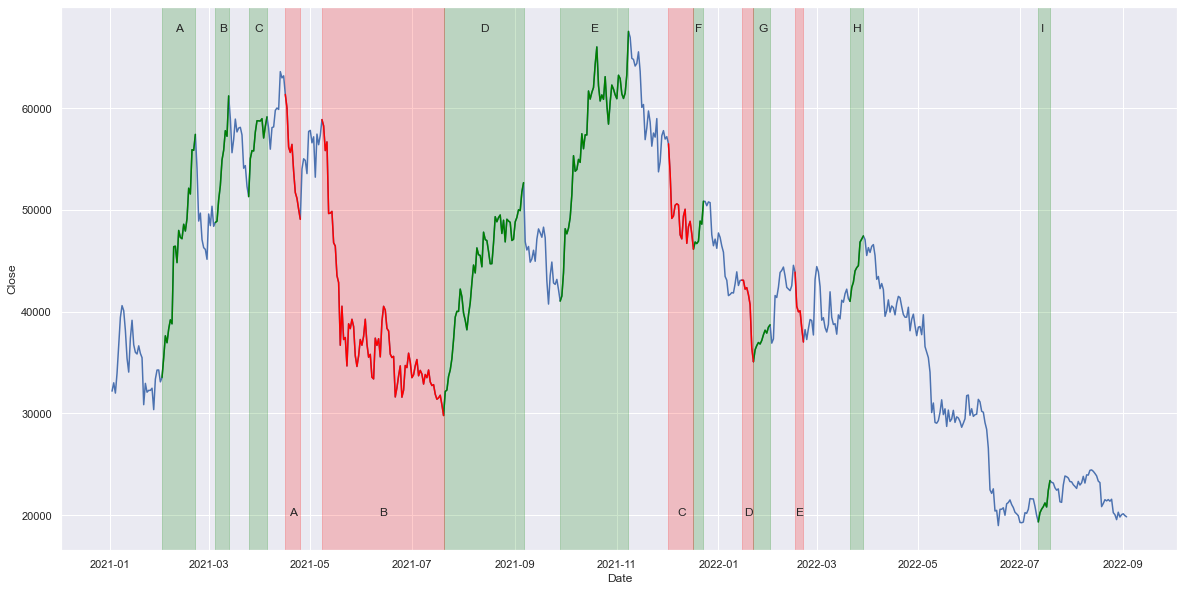

In [358]:
test = macd1.assign_trend(window_size=10, plot=True)
test

In [353]:
macd1.clean_assign_trend()

In [332]:
macd1.data_init

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,log_returns_hold,multiple_hold_acum,position,inv_sign
Date,,,,,,,,,,,,
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362,NaN,NaN,NaN,NaN,NaN,0,0
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750,NaN,NaN,NaN,0.025216,1.025536,0,0
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690,NaN,NaN,NaN,-0.031126,0.994107,0,0
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.997038,NaN,NaN,NaN,0.059492,1.055043,0,0
2021-01-06,33949.53,36939.21,33288.00,36769.36,127139.201310,NaN,NaN,NaN,0.079790,1.142675,0,0
2021-01-07,36769.36,40365.00,36300.00,39432.28,132825.700437,NaN,NaN,NaN,0.069920,1.225430,0,0
2021-01-08,39432.48,41950.00,36500.00,40582.81,139789.957499,NaN,NaN,NaN,0.028760,1.261184,0,0
2021-01-09,40586.96,41380.00,38720.00,40088.22,75785.979675,NaN,NaN,NaN,-0.012262,1.245814,0,0
2021-01-10,40088.22,41350.00,35111.11,38150.02,118209.544503,NaN,NaN,NaN,-0.049556,1.185581,0,0


In [25]:
test[np.isnan(test.macd_macd)].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2021-01-02 to 2021-01-26
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                25 non-null     float64
 1   High                25 non-null     float64
 2   Low                 25 non-null     float64
 3   Close               25 non-null     float64
 4   Volume              25 non-null     float64
 5   macd_diff           0 non-null      float64
 6   macd_macd           0 non-null      float64
 7   macd_signal         0 non-null      float64
 8   log_returns_hold    24 non-null     float64
 9   multiple_hold_acum  24 non-null     float64
 10  position            25 non-null     int64  
 11  inv_sign            25 non-null     int64  
 12  Up Trend            0 non-null      object 
 13  Down Trend          8 non-null      object 
dtypes: float64(10), int64(2), object(2)
memory usage: 2.9+ KB


In [7]:
pd.set_option('display.max_rows', None)

In [8]:
macd1.data_init

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,log_returns_hold,multiple_hold_acum,position,inv_sign,Up Trend,Down Trend
Date,,,,,,,,,,,,,,
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750,NaN,NaN,NaN,0.025216,1.025536,0,0,NaN,NaN
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690,NaN,NaN,NaN,-0.031126,0.994107,0,0,NaN,NaN
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.997038,NaN,NaN,NaN,0.059492,1.055043,0,0,A,NaN
2021-01-06,33949.53,36939.21,33288.00,36769.36,127139.201310,NaN,NaN,NaN,0.079790,1.142675,0,0,A,NaN
2021-01-07,36769.36,40365.00,36300.00,39432.28,132825.700437,NaN,NaN,NaN,0.069920,1.225430,0,0,A,NaN
2021-01-08,39432.48,41950.00,36500.00,40582.81,139789.957499,NaN,NaN,NaN,0.028760,1.261184,0,0,A,A
2021-01-09,40586.96,41380.00,38720.00,40088.22,75785.979675,NaN,NaN,NaN,-0.012262,1.245814,0,0,NaN,A
2021-01-10,40088.22,41350.00,35111.11,38150.02,118209.544503,NaN,NaN,NaN,-0.049556,1.185581,0,0,NaN,A
